<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/sepsioze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Integration of NeqSim and separator sizing tool

Test of separator sizing tool from https://github.com/Ahmedhassan676/Separator-Sizing/tree/main and integration with NeqSim.


In [ ]:
%%capture
!pip install neqsim==2.5.35
!pip install pyXSteam
!pip install -U pydantic

#NeqSim process simulation

In [ ]:
import os

if os.path.isfile('fluid1.e300'):
   print("Eclipse fluid file ok...")
else:
  print("Error...please provide an Eclipse fluid file...")

Eclipse fluid file ok...


In [ ]:
from pydantic import Field, field_validator
from pydantic.dataclasses import dataclass
from typing import Optional, List
from neqsim import jNeqSim
from functools import cache

@dataclass
class ProcessInput():
    """
    A class to define input parameters for the oil process.
    """
    flowRateHPsep: float = Field(ge=0.0, le=100000000.0, title="Flow rate to HP separator [kg/hr]")
    flowRateLPsep: float = Field(ge=0.0, le=1000000000.0, title="Flow rate to LP separator [kg/hr]")
    firstStagePressure: float = Field(ge=0.0, le=100.0, title="Pressure of first stage separator [bara]")
    firstStageTemperature: float = Field(ge=0.0, le=100.0, title="Temperature of first stage separator [C]")
    secondStagePressure: float = Field(ge=0.0, le=100.0, title="Second stage separator pressure [bara]")
    secondStageTemperature: float = Field(ge=0.0, le=100.0, title="Second stage separator temperature [C]")
    thirdStagePressure: float = Field(ge=0.0, le=100.0, title="Third stage separator pressure [bara]")
    thirdStageTemperature: float = Field(ge=0.0, le=100.0, title="Third stage separator temperature [C]")
    fourthStagePressure: float = Field(ge=0.0, le=100.0, title="Fourth stage separator pressure [bara]")
    fourthStageTemperature: float = Field(ge=0.0, le=100.0, title="Fourth stage separator temperature [C]")
    export_oil_temperature: float = Field(ge=0.0, le=100.0, title="Export oil temperature [C]")
    export_oil_pressure: float = Field(ge=0.0, le=100.0, title="Export oil pressure [bara]")
    export_gas_pressure: float = Field(ge=0.0, le=200.0, title="Export gas pressure [bara]")
    export_gas_temperature: float = Field(ge=0.0, le=100.0, title="Export gas temperature [C]")
    gasCoolerTemperature:float = Field(ge=0.0, le=100.0, title="Gas cooler temperature [C]")

@dataclass
class ProcessOutput:
    """
    A class to define output results from an Oil process simulation.
    """
    mass_balance: Optional[float] = None
    recompressor1_power: Optional[float] = None
    recompressor2_power: Optional[float] = None
    recompressor3_power: Optional[float] = None
    exportcompressor_power: Optional[float] = None
    gasexportflow: Optional[float] = None
    oilexportflow: Optional[float] = None
    export_gas_cooler_duty: Optional[float] = None

@cache
def getprocess():
    """
    The method creates a oil process object using neqsim
    """

    wellFluid = jNeqSim.thermo.util.readwrite.EclipseFluidReadWrite.read('fluid1.e300')
    wellFluid .setMultiPhaseCheck(True)
    LPwellFLuid = wellFluid.clone()

    wellStreamHP = jNeqSim.processSimulation.processEquipment.stream.Stream(wellFluid)
    wellStreamHP.setName("HP well stream")

    LPwellStream = jNeqSim.processSimulation.processEquipment.stream.Stream(LPwellFLuid)
    LPwellStream.setName("LP well stream")

    firstStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(wellStreamHP)
    firstStageSeparator.setName("1st stage separator")

    oilHeaterFromFirstStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(firstStageSeparator.getOilOutStream())
    oilHeaterFromFirstStage.setName("oil heater second stage")

    secondStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromFirstStage.getOutStream())
    secondStageSeparator.addStream(LPwellStream)
    secondStageSeparator.setName("2nd stage separator")

    oilHeaterFromSecondStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(secondStageSeparator.getOilOutStream())
    oilHeaterFromSecondStage.setName("oil heater third stage")

    thirdStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromSecondStage.getOutStream())
    thirdStageSeparator.setName("3rd stage separator")

    oilThirdStage =  wellStreamHP.clone()
    oilThirdStage.setName("third stage oil reflux")
    oilThirdStage.setFlowRate(10.0, 'kg/hr')

    oilThirdStageMixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer()
    oilThirdStageMixer.setName("third stage oil mixer")
    oilThirdStageMixer.addStream(thirdStageSeparator.getOilOutStream())
    oilThirdStageMixer.addStream(oilThirdStage)

    oilHeaterFromThirdStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(oilThirdStageMixer.getOutStream())
    oilHeaterFromThirdStage.setName("oil heater fourth stage")

    fourthStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromThirdStage.getOutStream())
    fourthStageSeparator.setName("4th stage separator")

    firstStageCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(fourthStageSeparator.getGasOutStream())
    firstStageCooler.setName("1st stage cooler")

    firstStageScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(firstStageCooler.getOutStream())
    firstStageScrubber.setName("1st stage scrubber")

    firstStageCompressor = jNeqSim.processSimulation.processEquipment.compressor.Compressor(firstStageScrubber.getGasOutStream())
    firstStageCompressor.setName("1st stage compressor")
    firstStageCompressor.setUsePolytropicCalc(True)
    firstStageCompressor.setPolytropicEfficiency(0.8)

    firststagegasmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("first stage mixer")
    firststagegasmixer.addStream(firstStageCompressor.getOutStream())
    firststagegasmixer.addStream(thirdStageSeparator.getGasOutStream())

    firstStageCooler2 = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(firststagegasmixer.getOutStream())
    firstStageCooler2.setName("1st stage cooler2")

    firstStageScrubber2 = jNeqSim.processSimulation.processEquipment.separator.Separator(firstStageCooler2.getOutStream())
    firstStageScrubber2.setName("1st stage scrubber2")

    firstStageCompressor2 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(firstStageScrubber2.getGasOutStream())
    firstStageCompressor2.setName("2nd stage compressor")
    firstStageCompressor2.setUsePolytropicCalc(True)
    firstStageCompressor2.setPolytropicEfficiency(0.8)

    secondstagegasmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("second Stage mixer")
    secondstagegasmixer.addStream(firstStageCompressor2.getOutStream())
    secondstagegasmixer.addStream(secondStageSeparator.getGasOutStream())

    secondStageCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(secondstagegasmixer.getOutStream())
    secondStageCooler.setName("2nd stage cooler")

    secondStageScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(secondStageCooler.getOutStream())
    secondStageScrubber.setName("2nd stage scrubber")

    secondStageCompressor = jNeqSim.processSimulation.processEquipment.compressor.Compressor(secondStageScrubber.getGasOutStream())
    secondStageCompressor.setName("3rd stage compressor")
    secondStageCompressor.setUsePolytropicCalc(True)
    secondStageCompressor.setPolytropicEfficiency(0.8)

    richGasMixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("fourth Stage mixer")
    richGasMixer.addStream(secondStageCompressor.getOutStream())
    richGasMixer.addStream(firstStageSeparator.getGasOutStream())

    dewPointControlCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(richGasMixer.getOutStream())
    dewPointControlCooler.setName("dew point cooler")

    dewPointScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(dewPointControlCooler.getOutStream())
    dewPointScrubber.setName("dew point scrubber")

    lpLiqmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("LP liq gas mixer");
    lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
    lpLiqmixer.addStream(firstStageScrubber2.getLiquidOutStream());
    lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
    lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

    lpResycle = jNeqSim.processSimulation.processEquipment.util.Recycle("LP liq resycle")
    lpResycle.addStream(lpLiqmixer.getOutStream())
    lpResycle.setOutletStream(oilThirdStage)
    lpResycle.setTolerance(1e-6)

    exportoil = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(fourthStageSeparator.getOilOutStream())
    exportoil.setName("export oil cooler")

    exportoilstream = jNeqSim.processSimulation.processEquipment.stream.Stream(exportoil.getOutStream())
    exportoilstream.setName('export oil')

    exportCompressor1 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(dewPointScrubber.getGasOutStream())
    exportCompressor1.setName("export gas compressor")
    exportCompressor1.setUsePolytropicCalc(True)
    exportCompressor1.setPolytropicEfficiency(0.8857)

    exportGasCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(exportCompressor1.getOutStream())
    exportGasCooler.setName("export gas cooler")

    exportGas = jNeqSim.processSimulation.processEquipment.stream.Stream(exportGasCooler.getOutStream())
    exportGas.setName("export gas")

    oilprocess = jNeqSim.processSimulation.processSystem.ProcessSystem()
    oilprocess.add(wellStreamHP)
    oilprocess.add(LPwellStream)
    oilprocess.add(firstStageSeparator)
    oilprocess.add(oilHeaterFromFirstStage)
    oilprocess.add(secondStageSeparator)
    oilprocess.add(oilHeaterFromSecondStage)
    oilprocess.add(thirdStageSeparator)
    oilprocess.add(oilThirdStage)
    oilprocess.add(oilThirdStageMixer)
    oilprocess.add(oilHeaterFromThirdStage)
    oilprocess.add(fourthStageSeparator)
    oilprocess.add(firstStageCooler)
    oilprocess.add(firstStageScrubber)
    oilprocess.add(firstStageCompressor)
    oilprocess.add(firststagegasmixer)
    oilprocess.add(firstStageCooler2)
    oilprocess.add(firstStageScrubber2)
    oilprocess.add(firstStageCompressor2)
    oilprocess.add(secondstagegasmixer)
    oilprocess.add(secondStageCooler)
    oilprocess.add(secondStageScrubber)
    oilprocess.add(secondStageCompressor)
    oilprocess.add(richGasMixer)
    oilprocess.add(dewPointControlCooler)
    oilprocess.add(dewPointScrubber)
    oilprocess.add(lpLiqmixer)
    oilprocess.add(lpResycle)
    oilprocess.add(exportoil)
    oilprocess.add(exportoilstream)
    oilprocess.add(exportCompressor1)
    oilprocess.add(exportGasCooler)
    oilprocess.add(exportGas)

    return oilprocess


def updateinput(process, locinput):
    """
    Update process with input parameters. Error handling added for non-existing units.
    """
    # Try accessing each unit and catch any potential AttributeError
    try:
      process.getUnit('HP well stream').setFlowRate(locinput.flowRateHPsep, 'kg/hr')
      process.getUnit('HP well stream').setTemperature(locinput.firstStageTemperature, "C")
      process.getUnit('HP well stream').setPressure(locinput.firstStagePressure, "bara")
      process.getUnit('LP well stream').setFlowRate(locinput.flowRateLPsep,'kg/hr')
      process.getUnit('LP well stream').setTemperature(locinput.secondStageTemperature, "C")
      process.getUnit('LP well stream').setPressure(locinput.secondStagePressure, "bara")
      process.getUnit('oil heater second stage').setOutTemperature(locinput.secondStageTemperature,'C')
      process.getUnit('oil heater second stage').setOutPressure(locinput.secondStagePressure,'bara')
      process.getUnit('oil heater third stage').setOutTemperature(locinput.thirdStageTemperature,'C')
      process.getUnit('oil heater third stage').setOutPressure(locinput.thirdStagePressure,'bara')
      process.getUnit('oil heater fourth stage').setOutTemperature(locinput.fourthStageTemperature,'C')
      process.getUnit('oil heater fourth stage').setOutPressure(locinput.fourthStagePressure,'bara')
      process.getUnit('export oil cooler').setOutTemperature(locinput.export_oil_temperature,'C')
      process.getUnit('export oil cooler').setOutPressure(locinput.export_oil_pressure,'bara')
      process.getUnit('1st stage cooler').setOutTemperature(locinput.gasCoolerTemperature,'C')
      process.getUnit('1st stage compressor').setOutletPressure(locinput.thirdStagePressure)
      process.getUnit('1st stage cooler2').setOutTemperature(locinput.gasCoolerTemperature,'C')
      process.getUnit('2nd stage compressor').setOutletPressure(locinput.secondStagePressure)
      process.getUnit('2nd stage cooler').setOutTemperature(locinput.gasCoolerTemperature,'C')
      process.getUnit('3rd stage compressor').setOutletPressure(locinput.firstStagePressure)
      process.getUnit('export gas compressor').setOutletPressure(locinput.export_gas_pressure, 'bara')
      process.getUnit('export gas cooler').setOutTemperature(locinput.export_gas_temperature,'C')
    except AttributeError as e:
        print(f"Failed to update unit parameters: {e}")


def getoutput(process):
    # update output
    #oilprocess.getUnit('HP well stream').getFluid().prettyPrint()
    outputparam = {
        'mass_balance': process.getUnit('HP well stream').getFlowRate('kg/hr')+process.getUnit('LP well stream').getFlowRate('kg/hr')-process.getUnit('export gas').getFlowRate('kg/hr')-process.getUnit('export oil').getFlowRate('kg/hr'),
        'recompressor1_power': process.getUnit('1st stage compressor').getPower()/1e3,
        'export_gas_cooler_duty':process.getUnit('export gas cooler').getDuty()/1e3,
        'recompressor2_power': process.getUnit('2nd stage compressor').getPower()/1e3,
        'recompressor3_power': process.getUnit('3rd stage compressor').getPower()/1e3,
        'exportcompressor_power': process.getUnit('export gas compressor').getPower()/1e3,
        'oilexportflow':process.getUnit('export oil').getFlowRate('idSm3/hr')*24.0,
        'gasexportflow':process.getUnit('export gas').getFlowRate('MSm3/day'),
    }
    return outputparam

def run_process_with_timeout(process, input_params, timeout=60, runstep=False):
    """Run the oil process calculation with a specified timeout."""
    updateinput(process=process, locinput=ProcessInput(**input_params))
    process.setRunInSteps(runstep)
    thread = process.runAsThread()
    thread.join(timeout*1000)
    if thread.isAlive():
        print('Process calculation timed out. Consider recreating the process object or adjusting parameters.')
        return None
    return ProcessOutput(**getoutput(process=process))

In [ ]:
# Create oil process (only do first time)
oilprocess = getprocess()

In [ ]:
inputparam = {
    'flowRateHPsep': 1000000.0,
    'flowRateLPsep': 300000.0,
    'firstStagePressure': 65.0,
    'firstStageTemperature': 85.0,
    'secondStagePressure': 22.0,
    'secondStageTemperature': 65.0,
    'thirdStagePressure': 4.5,
    'thirdStageTemperature': 63.5,
    'fourthStagePressure': 1.7,
    'fourthStageTemperature': 63.0,
    'export_oil_temperature': 20.0,
    'export_oil_pressure': 20.8,
    'export_gas_pressure': 126.5,
    'export_gas_temperature': 55.0,
    'gasCoolerTemperature': 25.0
}

# Update input parameters for process calculations.
# Note: In case of a process crash, the `oilprocess` object should be recreated to ensure stability for subsequent runs.
# Reusing the `oilprocess` object without unnecessary recreation can enhance numerical performance,
# as new calculations can leverage the solutions from previous runs. However, ensure to manage this carefully to avoid state-related errors.
# The `getprocess()` function is tasked with either creating a new `oilprocess` object or fetching an existing one,
# depending on the design to balance between computational efficiency and error resilience.

runstep=False

#timout parameter has unit seconds
results = run_process_with_timeout(process=oilprocess, input_params=inputparam, timeout=60,runstep=runstep)
if results and (results.mass_balance > 0.5 and runstep==False):
    print('Calculation failed to converge. Recreating process object...')
    print('Mass balance: ' , results.mass_balance, ' %')
    oilprocess = getprocess()
else:
    print('Calculation successful. Results: %s', results.__dict__ if results else 'No results')

Calculation successful. Results: %s {'mass_balance': 0.04321766062639654, 'recompressor1_power': 118.65480989452183, 'recompressor2_power': 964.9700505775024, 'recompressor3_power': 3557.7022617369566, 'exportcompressor_power': 6644.004455087077, 'gasexportflow': 5.91141487915347, 'oilexportflow': 32553.6994817719, 'export_gas_cooler_duty': -16149.443558661655}


In [ ]:
jNeqSim.util.unit.Units.activateFieldUnits()

import json
json_out = str(oilprocess.getReport_json())
json_object = json.loads(json_out)
#print(json.dumps(json_object, indent=2))
# Iterate through each key in the dictionary and convert the JSON strings to dictionaries
for key, value in json_object.items():
    json_object[key] = json.loads(value)

In [ ]:
json_object['1st stage scrubber']

{'name': '1st stage scrubber',
 'gasLoadFactor': 0.04049755961986651,
 'massflow': 5082.1022602173925,
 'gasFluid': {'name': 'DefaultName',
  'properties': {'DefaultName': {'molar mass': {'value': '36.14493952284722',
     'unit': 'lbm/lbmol'},
    'density': {'value': '0.1575605408693099', 'unit': 'lb/ft3'},
    'flow rate': {'value': '12.10845075876703', 'unit': 'barrel/day'}},
   'gas': {'molar mass': {'value': '36.14493952284722', 'unit': 'lbm/lbmol'},
    'density': {'value': '0.1575605408693099', 'unit': 'lb/ft3'},
    'flow rate': {'value': '12.10845075876703', 'unit': 'barrel/day'}}},
  'composition': {'DefaultName': {'C10-C12': {'value': '7.333475731050121E-5',
     'unit': 'mole fraction'},
    'C26-C28': {'value': '2.6085843646317263E-18', 'unit': 'mole fraction'},
    'n-hexane': {'value': '0.014617047634806864', 'unit': 'mole fraction'},
    'nitrogen': {'value': '3.948929772677911E-4', 'unit': 'mole fraction'},
    'CO2': {'value': '0.02348808269704877', 'unit': 'mole fra

In [ ]:
pres = float(json_object['1st stage scrubber']['gasFluid']['conditions']['gas']['pressure']['value'])
temp = float(json_object['1st stage scrubber']['gasFluid']['conditions']['gas']['temperature']['value'])
gasflow = float(json_object['1st stage scrubber']['gasFluid']['conditions']['gas']['mass flow']['value'])
gasdensity = float(json_object['1st stage scrubber']['gasFluid']['properties']['DefaultName']['density']['value'])
oilflow = float(json_object['1st stage scrubber']['oilFluid']['conditions']['oil']['mass flow']['value'])
oildensity = float(json_object['1st stage scrubber']['oilFluid']['properties']['DefaultName']['density']['value'])
gas_mass_fraction = float(gasflow)/float(oilflow)
oilflow
gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T= operating_conditions = gas_mass_fraction,gasflow,oilflow,oildensity,gasdensity,pres,temp

#Separator design functions
Test of separator sizing tool from https://github.com/Ahmedhassan676/Separator-Sizing/tree/main and integration with NeqSim.

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

# URL of the GitHub directory
url = "https://github.com/Ahmedhassan676/Separator-Sizing/tree/main/vessel_imgs"

# Function to download PNG files from the given URL
def download_png_files(url, download_folder='content/vessel_imgs'):
    # Create the download folder if it doesn't exist
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Send a request to the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to access {url}")

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the links to PNG files
    png_links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.endswith('.png'):
            full_url = "https://github.com" + href
            png_links.append(full_url)

    # Base URL for raw file downloads
    base_url = "https://raw.githubusercontent.com"
    repo_path = "Ahmedhassan676/Separator-Sizing/main/vessel_imgs/"

    for link in png_links:
        # Construct the full URL for the PNG file
        file_name = link.split('/')[-1]
        file_url = base_url + '/' + repo_path + file_name

        # Download the PNG file
        file_response = requests.get(file_url)
        if file_response.status_code == 200:
            with open(os.path.join(download_folder, file_name), 'wb') as file:
                file.write(file_response.content)
            print(f"Downloaded {file_name}")
        else:
            print(f"Failed to download {file_name}")

# Download PNG files from the specified URL
download_png_files(url)

Downloaded detailed_method_V2H.png
Downloaded detailed_method_V2H.png
Downloaded detailed_method_V2H_with_mesh.png
Downloaded detailed_method_V2H_with_mesh.png
Downloaded detailed_method_V2P.png
Downloaded detailed_method_V2P.png
Downloaded detailed_method_V2P_with_mesh.png
Downloaded detailed_method_V2P_with_mesh.png
Downloaded detailed_method_V3H.png
Downloaded detailed_method_V3H.png
Downloaded detailed_method_V3H_boot.png
Downloaded detailed_method_V3H_boot.png
Downloaded detailed_method_V3H_boot_with_mesh.png
Downloaded detailed_method_V3H_boot_with_mesh.png
Downloaded detailed_method_V3H_weir.png
Downloaded detailed_method_V3H_weir.png
Downloaded detailed_method_V3H_weir_with_mesh.png
Downloaded detailed_method_V3H_weir_with_mesh.png
Downloaded detailed_method_V3H_with_mesh.png
Downloaded detailed_method_V3H_with_mesh.png
Downloaded detailed_method_V3P.png
Downloaded detailed_method_V3P.png
Downloaded detailed_method_V3P_divertor.png
Downloaded detailed_method_V3P_divertor.png
Do

In [ ]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pyXSteam.XSteam import XSteam
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import os
from IPython.display import display
def find_number_range(number, num_list):
    num_list.sort()  # Sort the list to ensure it's in ascending order
    for i in range(len(num_list)):
        if num_list[i] <= number < num_list[i + 1]:
            return num_list[i], num_list[i + 1]
    return num_list[0], num_list[-1]
def nearest_size_in(D,convert_from_ft_to_in = True):
    """Returns the nearest API standard size in inches for a given diameter.

    Parameters:
        D (float): The diameter of the vessel in feet.
        convert_from_ft_to_in (bool, optional): Specifies whether the input diameter is in feet.
                                                If True, the input diameter is converted to inches. Default is True.
    Returns:
        int: The nearest API standard size in inches.
    """
    D = D*12
    if convert_from_ft_to_in == False:
        D = D
    API_STD_Sizes = [2,3,4,6,8,10,12,14,16,18,20,24]
    larger_D = [num for num in API_STD_Sizes if num > D]
    if larger_D:
        D_selected = min(larger_D)
        index_D = API_STD_Sizes.index(D_selected)
        suitable_size = API_STD_Sizes[index_D]
        return suitable_size
    else:
        return int(D)
def k_mist_eliminator(P):
    """Calculates the efficiency factor (K) of a mist eliminator based on the Vessel pressure  (P).

    Parameters:
        P (float): Vessel pressure  in psia (psia).

    Returns:
        float: The efficiency factor (K) of the mist eliminator.
    """
    if 1 <= P < 15:
        K = 0.1821+0.0029*P+0.046*math.log(P)
    elif  15 <= P < 40:
        K = 0.35
    else:
        K = 0.43-0.023*math.log(P)
    return K
def inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,pure_phase = False):
    """Performs sizing calculations for the inlet nozzle based on the volumetric flow rates,
    densities, and gas mass fraction of the two-phase fluid.

    Parameters:
        Qv (float): Volumetric flow rate of gas phase in cubic feet per second (cfs).
        Ql (float): Volumetric flow rate of liquid phase in gallons per second (cfs).
        rho_gas (float): Density of the gas phase in pounds per cubic foot (lb/ft^3).
        rho_oil (float): Density of the liquid phase in pounds per cubic foot (lb/ft^3).
        gas_mass_fraction (float): Mass fraction of the gas phase in the two-phase mixture.
        pure_phase (bool, optional): Specifies whether the sizing is for a pure gas phase.
                                     If True, the liquid flow rate is ignored. Default is False.

    Returns:
        float: The diameter of the inlet nozzle in inches."""
    if pure_phase == False:
        Ql = Ql/60
        Q_m = Ql + Qv

        rho_mix = rho_oil*(1-gas_mass_fraction) + rho_gas*gas_mass_fraction
        #print('Qm for inlet sizing is {} while rho mix is {}'.format(round(Q_m,2),rho_mix))
        d_n = np.sqrt((4*Q_m*(rho_mix**0.5))/(60*np.pi))
        #print('inlet nozzle diameter is {}'.format(d_n*12))
        d_n = nearest_size_in(d_n,convert_from_ft_to_in = True)
        #print(0.8*12)
        #print('inlet nozzle diameter is {} in.'.format(d_n))
    else:
        d_n = np.sqrt((4*Qv*(rho_gas**0.5))/(60*np.pi))
        d_n = nearest_size_in(d_n,convert_from_ft_to_in = True)
        #print(0.8*12)
        #print('nozzle diameter is {} in.'.format(d_n))
    return d_n
def k_GPSA_calculations(P,case_,rho_gas,rho_oil,mu_gas,dropletsize=150):
    """Calculates the separator K factor (K) based on the given parameters
    and the specific case.

    Parameters:
        P (float): Pressure in pounds per square inch (psi).
        case_ (str): Specifies the specific case for the calculation.
                     Valid options are:
                     - 'Most Vapors under vacuum'
                     - 'Glycol and amine solutions'
                     - 'Vertical separators without mist eliminators'
                     - 'Separator with mist eliminator'
                     - 'Separator without mist eliminator'
                     - 'Compressor Suction Scrubbers, molesieve scrubbers and expander inlet'
                     - 'Use York'
        rho_gas (float): Density of the gas phase in pounds per cubic foot (lb/ft³).
        rho_oil (float): Density of the liquid phase (oil) in pounds per cubic foot (lb/ft³).
        mu_gas (float): Viscosity of the gas phase in centipoise (cP).
        dropletsize (float, optional): Droplet size in micrometers (µm). Default is 150 µm.

    Returns:
        float: the separator K factor (K)."""
    Dp = dropletsize*3.208084E-6
    g = 32.1740
    P_g = P - 14.6959
    K = 0.35 -0.01*((P_g-100)/100)
    K_mist =k_mist_eliminator(P)
    #print('Original K is {} while K mist is {}'.format(K,K_mist))
    if case_ == 'Most Vapors under vacuum':
        K = 0.2
    elif case_ == ' Glycol and amine solutions':
        K = K*0.7 # from range 0.6-0.8
    elif case_ == 'Vertical separators without mist eliminators' or case_ =='Separator with mist eliminator' or case_ =='Separator without mist eliminator':
        K = K/2
    elif case_ =='Compressor Suction Scrubbers, molesieve scrubbers and expander inlet':
        K = K * 0.8
    elif 'Use York':
        K = K_mist
    else:
        K = 0.35 -0.01*((P_g-100)/100)
    X = math.log((0.95+(8*rho_gas*(Dp**3)*(rho_oil-rho_gas)))/(mu_gas**2))
    Y = 8.41-2.243*X+0.273*(X**2)-(1.865E-2)*(X**3)+(5.201E-4)*(X**4)
    Cd = np.exp(Y)
    Theo_K = np.sqrt((4*Dp*g)/(3*Cd))
    #print('Selected K equals {}'.format(K))
    return K

def LD_estimate(P,return_range = False):
    """An intial estimate of the Length/Diameter ratio (L/D) based on the given pressure.

    Parameters:
        P (float): Pressure in pounds per square inch (psi).

    Returns:
        float: the Length/Diameter ratio (L/D)."""
    P_g = P - 14.6959 # convert to psig
    if 0 <= P_g < 250:
        LD = 2 # from range 1.5-3
        range_of_LD = [1.5,3]
    elif 250 <= P_g < 500:
        LD = 3.5 # from range 3-4
        range_of_LD = [3,4]
    else:
        LD = 5 # from range 4-6
        range_of_LD = [4,6]
    if return_range == False:
        return LD
    else:
        return range_of_LD
def estimate_head_type(D,P):
    """An estimate of the Vessel Head Type based on the given pressure & Diameter.

    Parameters:
        P (float): Design Pressure in pounds per square inch (psig).
        D (float): Vessel Diameter in feet
    Returns:
        string: Vessel Head Type."""
    if D > 15 :
        head_type = 'Hemispherical heads'
    elif D < 15 and P > 100:
        head_type = 'Elliptical heads'
    else:
        head_type = 'Dished heads'
    return head_type
def weight_calculations(P,T,D,L,S,tc,head_type_estimate,E=0.85,boot=False):
    """Calculates the weight of a vessel based on the given parameters.

    Parameters:
        P (float): Opertaing pressure in pounds per square inch gauge (psig).
        T (float): Opertaing temperature in degrees Fahrenheit (°F).
        D (float): Diameter of the vessel in feet.
        L (float): Length of the vessel in feet.
        S (float): Vessel material stress in pounds per square inch (psi).
        tc (float): Corrosion allowance thickness in inches.
        head_type (str): Type of head. Valid options are:
                         - 'Elliptical heads'
                         - 'Hemispherical heads'
                         - 'Dished heads'
        E (float, optional): Welded Joint efficiency. Default is 0.85.

    Returns:
        tuple: A tuple containing the weight (W) of the vessel in pounds, the thickness (t)
               of the vessel shell and heads in inches, the area of the vessel shell (As) in square feet,
               the area of the heads (AH) in square feet, the design pressure (P) in psig, and the design
               temperature (T) in °F."""
	# Diameter in inch
    P = max(P+30,1.15*P) # design pressure in psig
    if T > 200: # T in Ferferhight
        T+=50
    else:
        T = 250
    #print('Design Pressure is {} While Design Temp. is {}'.format(P,T))
    # t are in inches so D will be multiplied by 12 for thickness equations
    ts,As = (P*D)*12/((2*S*E)-1.2*P) + tc, np.pi*D*L
    head_type = estimate_head_type(D,P)
    if head_type == 'Elliptical heads':
        th, AH = (P*D*12)/((2*S*E)-0.2*P) + tc, 1.09*D**2
    elif head_type == 'Hemispherical heads':
        th, AH = (P*D*12)/((2*S*E)-0.4*P) + tc, 1.571*D**2
    elif head_type == 'Dished heads':
        th, AH = (0.885*P*D*12)/((S*E)-0.1*P) + tc, 0.842*D**2

    t = max(ts,th)
    if boot == False:
        W = 490*(t/12)*(As+2*AH)
    else:
        W = 490*(t/12)*(As+AH)
    #print('As is {} ft2,while Ah is {}, ts is {} while th is {}'.format(round(As,2),round(AH,2),round(ts,2),round(th,2)))
    return W,t,As,AH,P,T,head_type
def height_area_conversion(input_,conversion_to_area = True):
    """ Converts between height ratio and cross sectional area values and vice versa based on the given input.

    Parameters:
        input_ (float): The input value for conversion.
        conversion_to_area (bool, optional): Specifies the direction of conversion.
                                            If True, converts height ratio to area. Default is True.

    Returns:
        float: The converted value.
    """
    X = input_
    if conversion_to_area == True:
        a,b,c,d,e,f,g,h,i = [4.755930E-5,3.924091,0.174875,-6.358805,5.668973,4.018448,-4.916411,-1.801705,-0.145348]
    else:
        a,b,c,d,e,f,g,h,i = [0.00153756,26.787101,3.299201,-22.923932,24.353518,-14.844824,-36.999376,10.529572,9.892851]
    Y = (a+c*X+e*(X**2)+g*(X**3)+i*(X**4))/(1+b*X+d*(X**2)+f*(X**3)+h*(X**4))

    return Y
def round_up_to_nearest(number,roundfig):
    # DONT COPY THIS
    #return math.ceil(number / roundfig) * roundfig
    return round(float(number) / roundfig) * roundfig
def terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True):
    """ Calculates the settling velocity of a liquid phase in a two-phase terminal settling system.

    Parameters:
        sg_oil (float): Specific gravity of the oil phase.
        rho_oil (float): Density of the oil phase in pounds per cubic foot (lb/ft³).
        rho_water (float): Density of the water phase in pounds per cubic foot (lb/ft³).
        mu_oil (float): Viscosity of the oil phase in cP (centipoise).
        mu_water (float): Viscosity of the water phase in cP (centipoise).
        High (bool, optional): Specifies whether the heavy liquid settling velocity is calculated.
                               If True, calculates the settling velocity of the heavy liquid out of the light.
                               If False, calculates the settling velocity of the light liquid out of the heavy.
                               Default is True.

    Returns:
        float: The settling velocity in inches per minute."""
    if sg_oil < 0.85:
        Ks = 0.333
        min_droplet_size = 127
    else:
        Ks = 0.163
        min_droplet_size = 89
    if High == True:
        # settling velocity of the heavy liquid out of the light: U_HL
        U = Ks*abs(rho_oil-rho_water)/mu_oil
    else:
        # settling velocity of the light liquid out of the heavy: U_LH
        U = Ks*abs(rho_oil-rho_water)/mu_water
    # U in in / min.
    return U
G_dict = {18: {'a': 0.0,  'b': 0.0,  'c': -0.007758911,  'd': 1.355712109,  'e': -88.14002119,  'f': 2538.925738,  'g': -19200.0},
 19: {'a': 0.0,  'b': 0.0,  'c': -0.009333985,  'd': 1.59204375,  'e': -101.1348069,  'f': 2849.196529,  'g': -21700.0},
 20: {'a': 0.0,  'b': 0.0,  'c': -0.010703127,  'd': 1.821245887,  'e': -115.3894582,  'f': 3239.336647,  'g': -25300.0},
 21: {'a': 0.0,  'b': 0.0,  'c': -0.00774214,  'd': 1.393300526,  'e': -92.99202652,  'f': 2740.039086,  'g': -21100.0},
 22: {'a': 0.0,  'b': 0.0,  'c': -0.00854096,  'd': 1.531810837,  'e': -101.8988994,  'f': 2987.616166,  'g': -23400.0},
 23: {'a': 0.0,  'b': 0.0,  'c': -0.00808391,  'd': 1.463895382,  'e': -98.2159285,  'f': 2901.595932,  'g': -22400.0},
 24: {'a': 0.0,  'b': 0.0,  'c': -0.011556738,  'd': 1.966110761,  'e': -124.5408311,  'f': 3491.859486,  'g': -27000.0},
 25: {'a': 5.04e-05,  'b': -0.01131533,  'c': 1.035229969,  'd': -48.99474696,  'e': 1250.167465,  'f': -16000.0,  'g': 85700.0},
 26: {'a': 3.52e-05,  'b': -0.008082432,  'c': 0.754747574,  'd': -36.33242286,  'e': 936.8400599,  'f': -11900.0,  'g': 64800.0},
 27: {'a': 3.06e-05,  'b': -0.006959776,  'c': 0.642547056,  'd': -30.45273589,  'e': 765.6692916,  'f': -9289.571187,  'g': 48200.0},
 28: {'a': 0.0,  'b': 0.0,  'c': -0.005461231,  'd': 1.130212111,  'e': -83.45103315,  'f': 2644.977458,  'g': -20200.0},
 29: {'a': 0.0,  'b': 0.0,  'c': -0.006893521,  'd': 1.326410133,  'e': -93.19941,  'f': 2853.587314,  'g': -21700.0},
 30: {'a': 0.0,  'b': 0.0,  'c': -0.004627341,  'd': 0.977931301,  'e': -73.41739993,  'f': 2366.529484,  'g': -17200.0}}
def calclculate_G(x,y,G_dict=G_dict):
    """Calculates the allowable downflow (G) in gallons per hour per square foot.

    Parameters:
        x (float): The density difference between the liquid and gas phases in lb/ft^3.
        y (float): The high liquid level above the interface in inches.
        G_dict (dict): A dictionary containing G values for different density differences.

    Returns:
        float: The calculated allowable downflow (G) in gallons per hour per squarefoot."""
    # G: allowable downflow in gph/ft^2, x: rho liquid minus rho gas, y: High liquid level above interface in inches
    # make ceil after 30 to avoid rrors
    tGs =find_number_range(x, list(G_dict.keys()))
    if x in tGs:
        G = G_dict[x]['a']*(y**6) + G_dict[x]['b']*(y**5) + G_dict[x]['c']*(y**4) + G_dict[x]['d']*(y**3) + G_dict[x]['e']*(y**2)+G_dict[x]['f']*(y)+G_dict[x]['g']
    else:
        G1 = calclculate_G(tGs[0],y,G_dict=G_dict) #9800 from graph
        G2 = calclculate_G(tGs[1],y,G_dict=G_dict) #9800 from graph
        G = np.interp(x,tGs,[G1,G2])

    return G
def Calculate_N(d,two_phase=True):
    """Calculates the distance from the tangent line to the nozzle center.

    Parameters:
        d (float): The diameter of the nozzle in inches.
        two_phase (bool, optional): Specifies the phase condition.
                                    If True, calculates the distance for a two-phase system.
                                    If False, calculates the distance for a three-phase system.
                                    Default is True.

    Returns:
        float: The distance N from the tangent line to the nozzle center in millimeters."""
    # N: distance from Tanget line to nozzle center
    if two_phase == True:
        N = max(d + 6,6) # all in inches
    else:
        N = max(0.5*d + 6,6)
    return N*25.4 # in mm
hold_surge_table_index = {'Unit Feed Drum':[10,5], 'Separators: Feed to column':[5,3],
                          'Separators: Feed to other drum or tankage with pump or through exchanger':[5,2],
                          'Feed to other drum or tankage without pump':[2,1],'Feed to fired heater':[10,3],
                          'Reflux or product accumulator: Reflux only':[3,2],'Reflux or product accumulator: Reflux and product Feed to column':[8,5],
                          'Reflux or product accumulator: Reflux and product Feed to other drum or tankage with pump or through exchanger':[8,4],
                          'Reflux or product accumulator: Reflux and product Feed to other drum or tankage without pump':[5,3],
                          'Reflux or product accumulator: Reflux and product Feed to fired heater':[13,5],
                          'Column Bottoms: Feed to another column':[5,2 ],'Column Bottoms: Feed to other drum or tankage with pump or through exchanger':[5,2],
                          'Column Bottoms: Feed to other drum or tankage without pump':[2,1],
                          'Column Bottoms: Feed to Fired Boiler & Bottom Product feed to another column':[8,2],
                          'Column Bottoms: Feed to Fired Boiler & Btm. Prod. feed to other drum or tankage with pump or through exchanger':[8,2],
                          'Column Bottoms: Feed to Fired Boiler & Btm. Prod. feed to other drum or tankage without pump':[5,1],'Compressor Suction / Interstage scrubber':[3,10]}

In [ ]:
def load_image(str,caption_=None):
    imgs_folder = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'vessel_imgs',str+'.png')
    print(str)
    return 'content/vessel_imgs/'+str+'.png'#detailed_method_V2H_with_mesh.png'

def write_results_on_imgs(image_name,list_of_results,list_of_coor_tuples,font_size = 15):
    img = Image.open(load_image(image_name,caption_=None))

    # Call draw Method to add 2D graphics in an image
    I1 = ImageDraw.Draw(img)
    myFont = ImageFont.load_default()#truetype('arial.ttf', font_size)
    # Add Text to an image
    for i,j in zip(list_of_results,list_of_coor_tuples):
        I1.text(j, str(i), font=myFont, fill=(255, 0, 0))
    # Display edited image
    display(img)
    #st.image(img)
def convert_to_float_or_string(s):
    try:
        return str(round(float(s), 5))
    except ValueError:
        return s
def create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Value','Units'],show_table=True):
    summary_table = pd.DataFrame(columns=list_of_columns)
    for i in list_of_table:
        summary_table.loc[len(summary_table.index)] = i
        summary_table['Value'] = summary_table['Value'].apply(lambda x: convert_to_float_or_string(x))
    if show_table:
        return summary_table
    else:
        return summary_table

#Vertical 2-phase separator

<ipython-input-16-045ce1c912ac>:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  D_vd = float(vars)


detailed_method_V2P_with_mesh


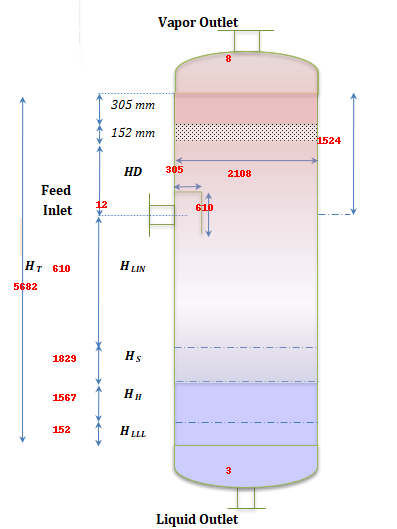

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,2108.2
1,Vessel Tan-Tan Length,L,mm,5681.9526
2,L/D,-,-,2.69517
3,Shell Thickness,ts,mm,84.80739
4,Head Thickness,tH,mm,84.80739
5,Total Weight,W,kg,31499.66872
6,Inlet Nozzle size,dF,inch,12.0
7,Liquid Outlet Nozzle size,dL,inch,3.0
8,Vapor Outlet Nozzle size,dv,inch,8.0
9,Height To Feed Nozzle,H_LIN,mm,609.6


In [ ]:
#----------- 2 phase Vertical Separator---------------------#
def estimate_LLL(calculations_options,D,P):
    D_ft = D/12
    D_array = np.array([0,4,6,8,10,12,16])
    LLL_array = np.array([9,9,10,11,12,13,15])
    if calculations_options == 'Two Phase (Gas - Oil) Vertical separator: As per API 12J':

        if D_ft <= 8 and P < 300:
            LLL = 15
        else:
            LLL = 6
    elif calculations_options == 'Two Phase (Gas - Oil) Horizontal Separator: As per API 12J':
        LLL = int(np.interp(D_ft,D_array,LLL_array))
        # LLL = 0.5*D_ft + 7
    return LLL/12


#----------- 2 phase Vertical Separator---------------------#
def calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=False):
    # This function Calculates The Total Height given the diameter
    HLLL = estimate_LLL('Two Phase (Gas - Oil) Vertical separator: As per API 12J',D_vd*12,P)
    HH = max(V_H/(np.pi*0.25*(D_vd**2)),1)
    HS = max(V_S/(np.pi*0.25*(D_vd**2)),6)


    d_n = inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)

    if inlet_divertor == True:
        HLIN = 12 + d_n
    else:
        HLIN = 12 + d_n*0.5
    HLIN = HLIN/ 12
    if mist_eliminator == True:
        H_D = 24 +0.5*d_n
        H_D += 6+12
        H_D = max((0.5*D_vd)+1.5,H_D/12) # HD in ft
    else:
        H_D = 36 + 0.5 *d_n
        H_D = max(0.5*D_vd,H_D/12) # HD in ft


    H_total=HLLL + HH + HS + HLIN + H_D
    if only_return_L == False:
        return HLLL,HH,HS,d_n,HLIN,H_D,H_total
    else:
        return H_total

def optimize_vessel_design_V2P(vars,P,T,V_H,V_S,inlet_divertor,mist_eliminator,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,return_output = False):
    D_vd = float(vars)

    HLLL,HH,HS,d_n,HLIN,HD,H_total = calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=False)
    # print('Total Height is {} ft or {} mm'.format(H_total,H_total*304.8))
    # print(HLLL , HH , HS , HLIN , HD )
    D = nearest_size_in(D_vd,convert_from_ft_to_in = True)
    LD = H_total/(D/12)
    #print(D,D_vd,U_v,K,Qv,Ql)
    W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D/12,H_total,17500,1/16,'Elliptical heads')

    # print('Weight is {} lbs,L is {} ft and D is {} in. L/D is {}'.format(W,H_total,D,LD))
    # print('------------------')
    if return_output == False:
        return W
    else:
        result_list = [W,H_total,D,t,As,AH,P,T,HLLL,HH,HS,d_n,HLIN,HD,H_total,head_type]
    return result_list
def constraint_VP2_1(x,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction):
	#
    D_vd = x[0]
    H_total = calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=True)
    return (H_total /x[0]) - 2
def constraint_VP2_2(x,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction):
	#
    D_vd = x[0]
    H_total = calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=True)
    return 2.5 - (H_total /x[0])



def detailed_V2P(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
    gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T = operating_conditions
    T_R = T +460
    hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
    #k_GPSA_calculations(P,None,rho_gas,rho_oil,0.013,dropletsize=100)
    # calculate terminal velocity
    K = k_GPSA_calculations(P,'Separator with mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
    U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
    # set U_v = 0.75 U_t
    U_v = 0.75* U_t
    Qv = Qg_lb /(3600*rho_gas)
    Ql = Q_oil_lb/(60*rho_oil)
    V_H , V_S = hold_up_time*Ql ,surge_time*Ql
    D_vd = np.sqrt(((4*Qv)/(np.pi*U_v))) # Inside diameter in ft

    con1= {'type':'ineq', 'fun': constraint_VP2_1,'args':(inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)}
    con2 = {'type':'ineq', 'fun': constraint_VP2_2,'args':(inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)}
    cons=[con1,con2]
    initial_guess = [D_vd]
    bounds = [(1,20)]
    result =minimize(optimize_vessel_design_V2P,args=(P,T,V_H,V_S,inlet_divertor,mist_eliminator,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
    result_list = optimize_vessel_design_V2P(result.x,P,T,V_H,V_S,inlet_divertor,mist_eliminator,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,return_output=True)
    W,L,D,t,As,AH,P_d,T_d,HLLL,HH,HS,d_n,HLIN,HD,H_total,head_type = result_list
    #print('Weight is {} lbs, D is {} ft  and L is {} ft.'.format(W,D/12,L))
    gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
    liquid_outlet_D = inlet_nozzzle_sizing(Ql/60,0,rho_oil,0,1,True)
    LD = L*12/D

    Dims_results = [d_n, gas_outlet_D,D*25.4,H_total*304.8,HLIN*304.8,HS*304.8,HH*304.8,HLLL*304.8,HD*304.8,liquid_outlet_D]
    for i,j in enumerate(Dims_results):
        Dims_results[i] = round(float(j))
    coord = [(96,199),(226,53),(228,168),(14,281),(53,263),(53,353),(53,392),(53,424),(317,135),(226,465)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
    if inlet_divertor:
        coord.append((166,164)) # roof
        Dims_results.append(round(d_n*25.4))
        coord.append((196,202)) # face
        Dims_results.append(round(d_n*2*25.4))
    list_of_table = [['Diameter of Drum', 'D', 'mm', D*25.4],
    ['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
    ['L/D','-', '-', LD],
    ['Shell Thickness', 'ts', 'mm', t*25.4],
    ['Head Thickness', 'tH', 'mm', t*25.4],
    ['Total Weight', 'W', 'kg', W*0.453592],
    ['Inlet Nozzle size', 'dF', 'inch', d_n],
    ['Liquid Outlet Nozzle size', 'dL', 'inch', liquid_outlet_D],
    ['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],

    ['Height To Feed Nozzle', 'H_LIN', 'mm', HLIN*304.8],
    ['Surge Liquid Level', 'Hs', 'mm', HS*304.8],
    ['High Liquid Level','HH' , 'mm', HH*304.8],
    ['Low Liquid Level', 'H_LLL', 'mm', HLLL*304.8],

    ['Holdup Time', 'TH', 'min', hold_up_time],
    ['Surge Time', 'TS', 'min',surge_time],
    ['MeshPad', '-', '-', mist_eliminator],
    ['Head Type', '-', '-',head_type],
    ['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
    ['Max. Operating Pressure', 'MOP', 'Barg', P],
    ['Design Pressure', 'DP', 'Barg', P_d],
    ['Design Temperature', 'DT', 'oC', T_d],
    ['Corrosion Allowance', 'C', 'mm', 1.5],
    ['Joint Efficiency', 'E', '-',  0.85]]
    if not mist_eliminator:
        write_results_on_imgs('detailed_method_V2P',Dims_results,coord)
    else:
        write_results_on_imgs('detailed_method_V2P_with_mesh',Dims_results,coord)
    summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
    return summary_table

# Calculations inputs
sep_case = 'Unit Feed Drum'
gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T= operating_conditions = (145600/(145600+46100)),145600,46100,38.83,4.01,975+14.6959,650
inlet_divertor, mist_eliminator = True,True
summary_table = detailed_V2P(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

## Design of 1st stage gas scrubber

detailed_method_V2P_with_mesh


<ipython-input-16-045ce1c912ac>:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  D_vd = float(vars)


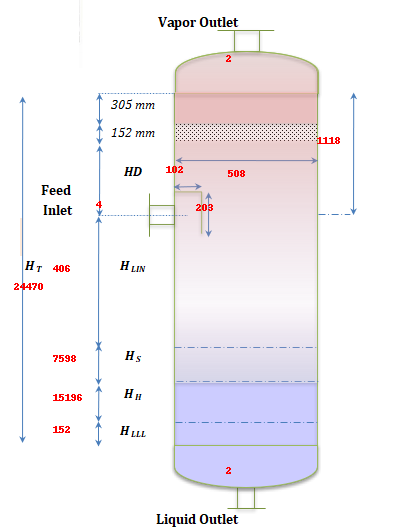

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,508.0
1,Vessel Tan-Tan Length,L,mm,24469.73535
2,L/D,-,-,48.16877
3,Shell Thickness,ts,mm,20.6314
4,Head Thickness,tH,mm,20.6314
5,Total Weight,W,kg,6415.04921
6,Inlet Nozzle size,dF,inch,4.0
7,Liquid Outlet Nozzle size,dL,inch,2.0
8,Vapor Outlet Nozzle size,dv,inch,2.0
9,Height To Feed Nozzle,H_LIN,mm,406.4


In [ ]:
pres = float(json_object['1st stage separator']['gasFluid']['conditions']['gas']['pressure']['value'])
temp = float(json_object['1st stage separator']['gasFluid']['conditions']['gas']['temperature']['value'])
gasflow = float(json_object['1st stage separator']['gasFluid']['conditions']['gas']['mass flow']['value'])
gasdensity = float(json_object['1st stage separator']['gasFluid']['properties']['DefaultName']['density']['value'])
oilflow = float(json_object['1st stage separator']['oilFluid']['conditions']['oil']['mass flow']['value'])
oildensity = float(json_object['1st stage separator']['oilFluid']['properties']['DefaultName']['density']['value'])
gas_mass_fraction = float(gasflow)/(float(oilflow)+float(gasflow))
gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T= operating_conditions = gas_mass_fraction,gasflow,oilflow,oildensity,gasdensity,pres,temp

summary_table = detailed_V2P(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

#Horizontal Two-Phase Sizing

detailed_method_V2H_with_mesh


<ipython-input-18-fa57efaf0e0c>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  D = float(vars)


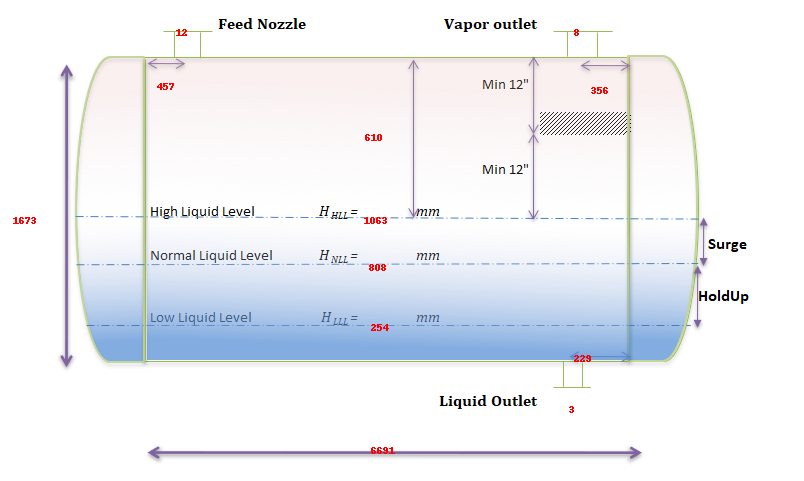

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,1672.78184
1,Vessel Tan-Tan Length,L,mm,6691.12735
2,L/D,-,-,4.0
3,Shell Thickness,ts,mm,67.61952
4,Head Thickness,tH,mm,67.61952
5,Total Weight,W,kg,21900.41999
6,Inlet Nozzle size,dF,inch,12.0
7,Liquid Outlet Nozzle size,dL,inch,3.0
8,Vapor Outlet Nozzle size,dv,inch,8.0
9,High Liquid Level,HHLL,mm,1063.18184


In [ ]:
def find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = True):

	Lmin_Ltime , Lmin_V	= -10 , -2
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated
			H_v = max(0.2*D,2)
		else:
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1



		while not (1.2 > (Lmin_Ltime / Lmin_V) > 0.8) and Lmin_Ltime < 0  :
			At = np.pi*0.25*(D**2) # ft2
			HLLL =round_up_to_nearest((0.5*D + 7),1)/12 # feet  #estimate_LLL(calculations_options,D,P)
			#print(D,HLLL)
			HLLL_D = HLLL/D # feet / feet
			#print('HLLL/D equals {}'.format(HLLL_D))
			#print(HLLL_D,10/(5*12),HLLL/D)

			ALLL_At = height_area_conversion(HLLL_D,conversion_to_area = True)
			ALLL = ALLL_At*At # ft^2
			#print(ALLL)
			Hv_D = H_v/(D) # feet / feet

			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At
			# 10 calculate minimum length
			Lmin_Ltime = (V_H+V_S)/(At-A_v-ALLL)

			# Liquid dropout time
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v

			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi
			if not 1.2 > abs(Lmin_Ltime / Lmin_V):
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(Lmin_Ltime / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.01
				Hv_D = H_v/(D)
			if Lmin_Ltime <0 :
				D +=0.01
				Hv_D = H_v/(D)

	#print('Hv/D equals {}'.format(Hv_D))
	# minpulate assumed LD ratio and minpulate Hv
	#print('length is {} while min L is {}'.format(Lmin_Ltime , Lmin_V))
	if Lmin_Ltime < Lmin_V:
		L = Lmin_V
	else:
		L = Lmin_Ltime

	A_NLL = ALLL + V_H/L
	A_NLL_ration = A_NLL/At
	H_NLL = height_area_conversion(A_NLL_ration ,conversion_to_area = False)*D
	H_HLL = D- H_v
	LD = float(L/D)
	if return_output_LD == False:
		return LD
	else:
		result_list = [At,HLLL,HLLL_D,ALLL_At,ALLL,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,H_v,min_Hv,D]
		return result_list
def optimize_vessel_design(vars,P,T,V_H,V_S,U_v,Qv,mist_eliminator,return_output = False):
	D = float(vars)
	#D = ((4*(V_H + V_S))/(np.pi*0.6*LD))**(1/3) # D in feet
	#D = round_up_to_nearest(D,0.5)
	At,HLLL,HLLL_D,ALLL_At,ALLL,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,H_v,min_Hv,D = find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = True)
	W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D,L,17500,1/16,'Elliptical heads')
	# print('HLLL is {} ft, NLL is {} while H_HLL is {} ft and Hv is {} ft'.format(HLLL,H_NLL,H_HLL,H_v))
	# print('Weight is {} lbs,L is {} ft and D is {} ft. L/D is {}'.format(W,L,D,LD))
	# print('----------------------------------')
	if return_output == False:
		return W
	else:
		result_list = [W,t,As,AH,P,T,At,HLLL,HLLL_D,ALLL_At,ALLL,H_v,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,D,min_Hv,head_type]
		return result_list
def constraint_HP2_6(x,P,V_H,V_S,U_v,Qv,mist_eliminator):
	D = x[0]
	return LD_estimate(P,return_range=True)[1] - find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = False)
def constraint_HP2_1_5(x,P,V_H,V_S,U_v,Qv,mist_eliminator):
	D = x[0]
	return find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = False) - LD_estimate(P,return_range=True)[0]

#-----------------------2 phase horizontal--------------------#


def detailed_V2H(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):

	gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T = operating_conditions
	T_R = T +460
	hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
	K = k_GPSA_calculations(P,'Separator with mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
	U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
	# set U_v = 0.75 U_t
	U_v = 0.75* U_t # ft/s
	Qv = Qg_lb /(3600*rho_gas)
	Ql = Q_oil_lb/(60*rho_oil)
	V_H , V_S = hold_up_time*Ql ,surge_time*Ql # ft3

	LD = LD_estimate(P) # LD initial estimate (assumption)
	initial_D = ((4*(V_H + V_S))/(np.pi*0.6*LD))**(1/3) # D in feet
	#print('initial_D {} ft'.format(initial_D))
	if mist_eliminator: # used for initial guess and to be minpulated
		H_v = max(0.2*initial_D,2)
	else:
		H_v = max(0.2*initial_D,1) # Hv in feet

	d_n = inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)
	#print(LD,H_v,initial_D)

	con1,con2 = {'type':'ineq', 'fun': constraint_HP2_6,'args':(P,V_H,V_S,U_v,Qv,mist_eliminator)},{'type':'ineq', 'fun': constraint_HP2_1_5,'args':(P,V_H,V_S,U_v,Qv,mist_eliminator)}
	cons=[con1,con2]
	initial_guess = [initial_D]

	bounds = [(1,20)]

	result =minimize(optimize_vessel_design,args=(P,T,V_H,V_S,U_v,Qv,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
	result_list = optimize_vessel_design(result.x,P,T,V_H,V_S,U_v,Qv,mist_eliminator,return_output=True)
	W,t,As,AH,P_d,T_d,At,HLLL,HLLL_D,ALLL_At,ALLL,H_v,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,D,min_Hv,head_type = result_list
	#print('Weight is {} lbs, D is {} ft vs Hv is {} ft and L is {} ft.'.format(W,D,H_v,L))
	gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
	liquid_outlet_D = inlet_nozzzle_sizing(Ql/60,0,rho_oil,0,1,True)
	gas_N = Calculate_N(gas_outlet_D)
	liquid_N = Calculate_N(liquid_outlet_D)
	Feed_N = Calculate_N(d_n)

	Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_outlet_D,liquid_N,D*304.8,L*304.8,HLLL*304.8, H_NLL*304.8, H_HLL*304.8,H_v*304.8]
	for i,j in enumerate(Dims_results):
		Dims_results[i] = round(float(j))
	coord = [(176,27),(157,81),(574,27),(591,85),(569,404),(574,353),(13,215),(371,445),(371,322),(369,262),(364,215),(365,132)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
	list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Liquid Outlet Nozzle size', 'dL', 'inch', liquid_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],

	['High Liquid Level','HHLL' , 'mm', H_HLL*304.8],
	['Normal Liquid Level', 'HNLL', 'mm', H_NLL*304.8],
	['Low Liquid Level', 'HLL', 'mm', HLLL*304.8],

	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', '-', '-', 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]


	if not mist_eliminator:
		write_results_on_imgs('detailed_method_V2H',Dims_results,coord)
	else:
		write_results_on_imgs('detailed_method_V2H_with_mesh',Dims_results,coord)
	summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
	return summary_table
# Calculations inputs
sep_case = 'Unit Feed Drum'
gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T= operating_conditions = (145600/(145600+46100)),145600,46100,38.83,4.01,975+14.6959,650
inlet_divertor, mist_eliminator = True,True
summary_table = detailed_V2H(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

#Vertical threee phase separator

detailed_method_V3P_divertor_with_mesh


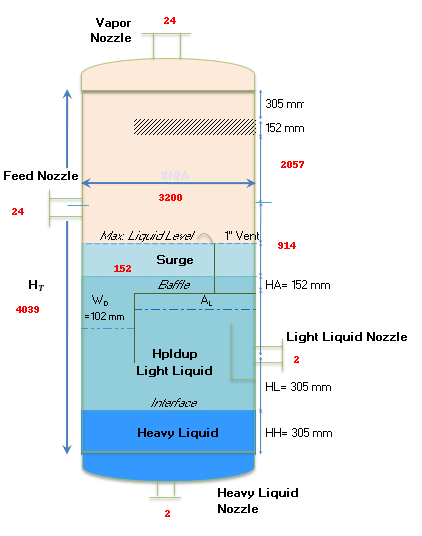

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,3200.4
1,Vessel Tan-Tan Length,L,mm,4038.6
2,L/D,-,-,1.2619
3,Shell Thickness,ts,mm,21.12608
4,Head Thickness,tH,mm,21.12608
5,Total Weight,W,kg,10435.72947
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,2.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [ ]:
#--------------------Vertical 3 phase----------------#
def optimize_V3P_design(vars,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output = False):
    D_vd,H_L,H_H,H_R = vars
    #H_L,H_H = 1,1
    t_HL = (12*H_L)/U_HL
    t_LH = (12*H_H)/U_LH
    # 9. if there's a baffle plate
    #H_R = 1 # 12 in or 1 ft is assumed in assumed
    H_R_H_L = H_R + H_L
    y = rho_oil-rho_gas
    #print(H_R_H_L*12)

    G = calclculate_G(H_R_H_L*12,y)
    # print('G Value is {}'.format(G))
    A_D1 = 7.48*60*(Q_LL+Q_HL)/G

    # Assume W_D = 4 inches
    W_D = 4
    WD_D = W_D/(D_vd*12)
    At = np.pi*0.25*(D_vd**2) # ft2
    Ad_At = height_area_conversion(WD_D,conversion_to_area = True)
    A_D2 = At*Ad_At
    Ad = max(A_D1,A_D2)
    Al,Ah = (At-Ad), At

    PHI_LL = (Al*H_L)/Q_LL
    PHI_HL = (Ah*H_H)/Q_HL
    # if phi_LL < t_HL or phi_HL < t_LH, increase the diameter and repeat the procedure from step 7 (liquid separation is controlling)
    H_R_calculated = Q_LL*hold_up_time/Al # Check the value with that assumed in step 9b
    # print('Calculated HR is {}'.format(H_R))
    H_S = max((Q_LL + Q_HL)*surge_time/At,6/12)
    # 12. Calculate the vessel height using the guidelines
    H_A = 6 /12 # feet min.
    H_BN = 0.5*(d_n/12)+max(2,H_S + 0.5) # feet

    if mist_eliminator == True:
        H_D = 24 +0.5*d_n
        H_D += 6+12
        H_D = max((0.5*D_vd)+1.5,H_D/12) # HD in ft
    else:
        H_D = 36 + 0.5 *d_n
        H_D = max(0.5*D_vd,H_D/12) # HD in ft
    H_t = L = H_H+H_L+H_R+H_A + H_BN+H_D # total height in feet
    # print(H_H,H_L,H_R,H_A , H_BN,H_D )
    LD = H_t/D_vd
    W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D_vd,L,17500,1/16,'Elliptical heads')

    # print('Weight is {} lbs,L is {} ft and D is {} ft. L/D is {}'.format(W,L,D_vd,LD))
    # print('----------------------------------')
    if return_output == False:
        return H_R - H_R_calculated
    else:
        result_list = [W,L,D_vd,LD,t,As,AH,P,T,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H,head_type]
        return result_list

def phi_LL_constraint(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator):
    W,L,D_vd,LD,t,As,AH,P,T,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H,head_type = optimize_V3P_design(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output=True)
    return PHI_LL - t_HL
def phi_HL_constraint(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator):
    W,L,D_vd,LD,t,As,AH,P,T,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H ,head_type= optimize_V3P_design(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output=True)
    return PHI_HL - t_LH

def detailed_V3P(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
    Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T = operating_conditions
    hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]



    Q_L_mix = Q_oil_lb+ Q_water_lb
    rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
    Ql_mix = Q_L_mix/(60*rho_L)
    # 1. Calculate Terminal Velocity

    K = k_GPSA_calculations(P,'Use York',rho_gas,rho_oil,0.013,dropletsize=100)
    U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
    # set U_v = 0.75 U_t
    U_v = 0.75* U_t # ft/s
    Qv = Qg_lb /(3600*rho_gas)
    Qll = Q_oil_lb/(60*rho_oil)
    Qhl = Q_water_lb/(60*rho_water)
    gas_vol_fraction = Qv*60/((Qv*60)+Qll+Qhl)
    #print(gas_vol_fraction )
    D_vd = np.sqrt(((4*Qv)/(np.pi*U_v))) # Inside diameter in ft
    #print('Before D {}'.format(D_vd))
    if mist_eliminator:
        D_vd = round_up_to_nearest((D_vd*12)+3,6)/12
        #print('After D {}'.format(D_vd))
    sg_oil = rho_oil/62.4
    U_HL = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True)
    U_LH = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False)
    #print(U_HL,U_LH)
    Q_LL = Q_oil_lb/(60*rho_oil)
    Q_HL = Q_water_lb/(60*rho_water)
    #print(Q_LL,Q_HL)
    d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
    # 7./8. Assume H_L = 1 # ft which is minimum
    initial_guess = [D_vd,1,1,1]
    bounds = [(D_vd,20),(1,D_vd),(1,D_vd*2),(1,D_vd)]
    con1= {'type':'ineq', 'fun': phi_LL_constraint,'args':(P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator)}
    con2 = {'type':'ineq', 'fun': phi_HL_constraint,'args':(P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator)}
    cons=[con1,con2]
    result =minimize(optimize_V3P_design,args=(P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
    result_list = optimize_V3P_design(result.x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output=True)
    W,L,D,LD,t,As,AH,P_d,T_d,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H,head_type = result_list
    # print('Weight is {} lbs, D is {} ft and L is {} ft.'.format(W,D,L))
    # print('HH {}, HL {}, HR {}, H_A {}, H_BN {}, H_D {}'. format(H_H,H_L,H_R,H_A,H_BN,H_D))
    # print('H_R is {},phi_LL is {} while t_HL is {}, phi_HL is {} while t_LH is {}'.format(H_R,PHI_LL , t_HL,PHI_HL , t_LH))

    gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
    liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
    liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)



    Dims_results = [d_n,gas_outlet_D,liquid_L_outlet_D,liquid_H_outlet_D ,D*304.8,L*304.8,H_D*304.8,H_BN*304.8,H_S*304.8] # feed D,gas d, Light D, Heavy D,D,L,H_D,H_BN,H_S
    for i,j in enumerate(Dims_results):
        Dims_results[i] = round(float(j))
    coord = [(12,206),(164,15),(294,354),(165,508),(159,192),(16,304),(281,159),(278,240),(114,263)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
    list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
    ['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
    ['L/D','-', '-', LD],
    ['Shell Thickness', 'ts', 'mm', t*25.4],
    ['Head Thickness', 'tH', 'mm', t*25.4],
    ['Total Weight', 'W', 'kg', W*0.453592],
    ['Inlet Nozzle size', 'dF', 'inch', d_n],
    ['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
    ['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
    ['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
    ['Disengagement height','H_D' , 'mm', H_D*304.8],
    ['Height from above baffle to feed nozzle','H_BN' , 'mm', H_BN*304.8],
    ['Surge Height','H_S' , 'mm', H_S*304.8],
    ['Liquid Level Above baffle','H_A' , 'mm', H_A*304.8],
    ['Height from liquid nozzle to baffle', 'H_R', 'mm', H_R*304.8],
    ['Light Liquid Level', 'H_LL', 'mm', H_L *304.8],
    ['Heavy Liquid Level', 'H_HL', 'mm', H_H *304.8],
    ['Holdup Time', 'TH', 'min', hold_up_time],
    ['Surge Time', 'TS', 'min',surge_time],
    ['MeshPad', '-', '-', mist_eliminator],
    ['Head Type', '-', '-', head_type],
    ['Material/Alloy grade and type:', '-', '-', 'CS'],
    ['Max. Operating Pressure', 'MOP', 'Barg', P],
    ['Design Pressure', 'DP', 'Barg', P_d],
    ['Design Temperature', 'DT', 'oC', T_d],
    ['Corrosion Allowance', 'C', 'mm', 1.5],
    ['Joint Efficiency', 'E', '-',  0.85]]

    if not mist_eliminator and inlet_divertor:
        write_results_on_imgs('detailed_method_V3P_divertor',Dims_results,coord)
    else:
        write_results_on_imgs('detailed_method_V3P_divertor_with_mesh',Dims_results,coord)
    summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
    return summary_table

# Calculations inputs
Qg_lb, rho_gas = 415000,0.6973 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 16500,1300,53.95,62.11
mu_oil,mu_water = 0.63, 0.764
sg_oil = rho_oil/rho_water
P = 165 # psia
T = 100 # assumed
hold_up_time,surge_time=25,5
inlet_divertor, mist_eliminator = True,True
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
sep_case = 'Unit Feed Drum'
summary_table= detailed_V3P(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

# Horizontal Three-Phase Separator Sizing (No weir, No Boot)

detailed_method_V3H_with_mesh


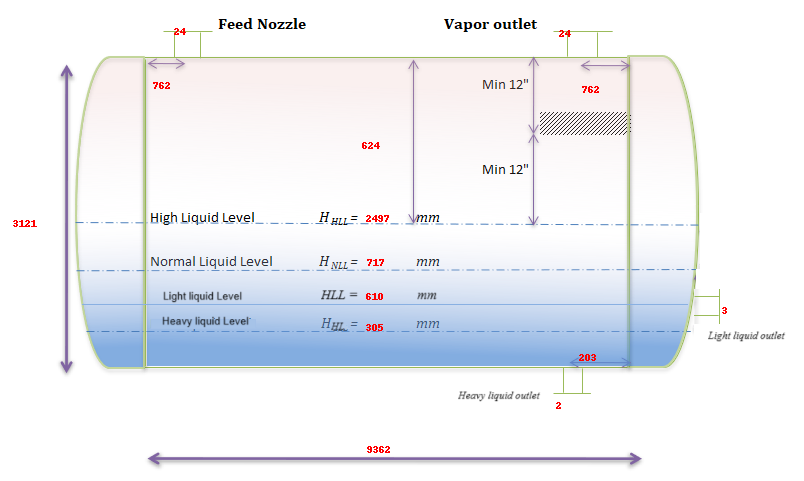

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,3120.66671
1,Vessel Tan-Tan Length,L,mm,9362.00013
2,L/D,-,-,3.0
3,Shell Thickness,ts,mm,11.80294
4,Head Thickness,tH,mm,11.80294
5,Total Weight,W,kg,10022.30833
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,3.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [ ]:
#  --------H3P with no boots or weir----------------- #


def find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= True):
	Lmin_Ltime , Lmin_V	= -10 , -2
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated
			H_v = max(0.2*D,2)
		else:
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1

		while (not 1.2 > (Lmin_Ltime / Lmin_V) > 0.8) and Lmin_Ltime < 0:
			# feet / feet
			At = np.pi*0.25*(D**2) # ft2
			Hv_D = H_v/(D)
			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At

			# step 7: set the heights of H_HL and H_LL

			A_HL,A_LL = height_area_conversion(H_HL/D,conversion_to_area = True)*At,height_area_conversion(H_LL/D,conversion_to_area = True)*At
			H_HLplusH_LL_At = height_area_conversion((H_HL+ H_LL)/D,conversion_to_area = True)
			A_HLplusA_LL = H_HLplusH_LL_At*At # ft^2

			# 9 calculate minimum length

			Lmin_Ltime = (V_H+V_S)/(At-A_v-A_HLplusA_LL)

			#calculate actual vapor velocity
			# Liquid dropout time
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v
			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi

			if abs(Lmin_Ltime / Lmin_V) > 1.2 and H_v > min_Hv:
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(Lmin_Ltime / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.02
				Hv_D = H_v/(D)
			if Lmin_Ltime <0 :
				D +=0.01
				Hv_D = H_v/(D)
	#print('Lmin1 is {} while Lmin2 is {}'.format(round(Lmin_Ltime,2),round(Lmin_V,2)))
	if Lmin_Ltime < Lmin_V:
		L = Lmin_V
	else:
		L = Lmin_Ltime
	#print('Hv/D equals {} as D is {} feet and Hv is {} feet'.format(round(Hv_D,3),D,H_v))
	# print('D is {}, Hv, H_HL,H_LL total is {}'.format(D, (H_v+H_HL+H_LL)))
	# print('At is {} ft2,Av={} ft2,A_HLplusA_LL is {} and D {}, H_V {}, H_HL and H_LL are {} & {}'.format(At, A_v, A_HLplusA_LL,D,H_v,H_HL,H_LL))
	U_HL = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True)
	U_LH = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False)


	t_HL = 12*(D-H_v-H_HL)/U_HL
	t_LH = 12*H_HL/U_LH

	phi_HL = A_HL*L/Q_HL
	phi_LL = (At-A_v-A_HL)*L/Q_LL

	L_max1 = t_LH*Q_HL/A_HL
	L_max2 = (t_HL*Q_LL)/(At-A_v-A_HL)
	L_max = max(L_max1,L_max2)
	#print('max length is {}'.format(round(L_max,2)))
	# step 18 Calculate L/D if LD < 1.5*0.8, decrease, and if L/D > 6*1.2, then increase D
	LD = L/D
	H_HLL = D - H_v
	A_NLL = (A_HL+A_LL) + V_H/L
	NLL = height_area_conversion(A_NLL/At,conversion_to_area = False)*D
	#print('D is {}, Chosen L is {}, Hv is {}, HLL is {}, NLL is {}, H_HL is {},HLL is {} '.format(D,L,H_v,H_HLL, NLL, H_HL,H_LL))

	if return_output_LD == True:
		return [At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,H_v]
	else:
		return LD
def optimize_vessel_design_H3phase(vars,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,return_output = False):
	D,H_HL,H_LL = vars
	At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,H_v = find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= True)
	W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D,L,17500,1/16,'Dished heads')
	#print(W,L,D,LD)
	#print('---------------------')
	if return_output == False:
		return W
	else:
		result_list = [W,L,D,H_v,H_HL, H_LL ,t,As,AH,P,T,At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,head_type  ]
		return result_list



def LD_constraint_1_HP3_no_weir_or_boot(x,P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water):
	D,H_HL,H_LL = x[0],x[1],x[2]
	return LD_estimate(P,return_range=True)[1] - find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= False)
def LD_constraint_2_HP3_no_weir_or_boot(x,P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water):
	D,H_HL,H_LL = x[0],x[1],x[2]
	return  find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= False) - LD_estimate(P,return_range=True)[0]
def detailed_V3H_no_weir_or_boot(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
	Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T= operating_conditions
	hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
	Q_L_mix = Q_oil_lb+ Q_water_lb
	rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
	Ql_mix = Q_L_mix/(60*rho_L)
	# 1. Calculate Terminal Velocity
	gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
	#print('mass fraction is {}'.format(round(gas_mass_fraction,3)))
	K = k_GPSA_calculations(P,'Separator without mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
	U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
	# set U_v = 0.75 U_t
	U_v = 0.75 * U_t
	#print('velocity is {} ft/s'.format(U_v))
	Qv = Qg_lb /(3600*rho_gas)
	Qll = Q_oil_lb/(60*rho_oil)
	Qhl = Q_water_lb/(60*rho_water)
	gas_vol_fraction = Qv*60/((Qv*60)+Qll+Qhl)
	V_H , V_S = hold_up_time*Qll ,surge_time*Qll # ft3
	#print('VHoldup and Vsurge equals {} and {} , total is {} ft3 '.format(round(V_H),round(V_S),(round(V_H)+round(V_S))))
	Q_LL = Q_oil_lb/(60*rho_oil) # ft3/min
	Q_HL = Q_water_lb/(60*rho_water) # ft3/min
	#step 5
	LD = LD_estimate(P)
	#print('assumed LD is {}'.format(round(LD)))# LD initial estimate (assumption)
	initial_D = round(((4*(V_H + V_S))/(np.pi*0.5*LD))**(1/3)) # D in feet
	sg_oil = rho_oil/62.4
	#print(initial_D)
	#print('-----------------------------------------')
	con1 ={'type':'ineq', 'fun': LD_constraint_1_HP3_no_weir_or_boot, 'args':(P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water)}
	con2 = {'type':'ineq', 'fun': LD_constraint_2_HP3_no_weir_or_boot, 'args':(P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water)}#, {'type':'eq', 'fun': true_LD_constraint, 'args':(V_S,V_H)},,{'type':'eq', 'fun': NLL_constraint, 'args':(V_S,V_H)}
	cons=[con1,con2,]
	initial_guess = [initial_D,1,1]
	if mist_eliminator:
		min_Hv = 2
	else: min_Hv = 1
	bounds = [(1,20),(1,2),(1,2)]
	result =minimize(optimize_vessel_design_H3phase,args=(P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
	result_list = optimize_vessel_design_H3phase(result.x,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,return_output=True)
	W,L,D,H_v,H_HL, H_LL,t,As,AH,P_d,T_d,At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,head_type = result_list
	#print('Weight is {}, D is {} vs Hv is {} and L is {},LD assumed {}'.format(W,D,H_v,L,result.x[1]))
	d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
	gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
	liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
	liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)
	gas_N = Calculate_N(gas_outlet_D)
	liquid_L_N = Calculate_N(liquid_L_outlet_D)
	liquid_H_N = Calculate_N(liquid_H_outlet_D)
	Feed_N = Calculate_N(d_n)

	Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_L_outlet_D,liquid_H_outlet_D,liquid_H_N  ,D*304.8,L*304.8,H_HLL*304.8, NLL*304.8, (H_LL+H_HL)*304.8,H_HL*304.8,H_v*304.8]
	for i,j in enumerate(Dims_results):
		Dims_results[i] = round(float(j))
	coord = [(174,26),(153,80),(559,28),(582,84),(722,305),(556,400),(579,352),(13,218),(367,444),(366,213),(367,257),(366,291),(366,322),(362,140)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
	list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
	['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
	['High Light Liquid Level','HHLL' , 'mm', H_HLL*304.8],
	['Normal Light Liquid Level', 'HNLL', 'mm', NLL*304.8],
	['Low Light Liquid Level', 'HLL', 'mm', H_LL*304.8],
	['Heavy Liquid Level', 'HHL', 'mm', H_HL*304.8],
	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]
	if not mist_eliminator:
		write_results_on_imgs('detailed_method_V3H',Dims_results,coord)
	else:
		write_results_on_imgs('detailed_method_V3H_with_mesh',Dims_results,coord)
	summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
	return summary_table

# Calculations inputs
Qg_lb, rho_gas = 235000,0.19 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 45000,7500,40.5,62.00
mu_oil,mu_water = 0.24, 0.682
sg_oil = rho_oil/rho_water
P = 25 + 14.6959 # psia
T = 100 # F
inlet_divertor, mist_eliminator = False,True
sep_case = 'Unit Feed Drum'
#sep_case ='Separators: Feed to column'
#operating_conditions = (1940.8372169999998, 0.145070322, 31128.462782999995, 11023.099999999999, 40.779063400800005, 61.817531160436836, 0.4, 0.5960689122848406, 14.2233, 113.0)
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
summary_table = detailed_V3H_no_weir_or_boot(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

# Horizontal Three-Phase Separator Sizing (With Boot)

detailed_method_V3H_boot_with_mesh


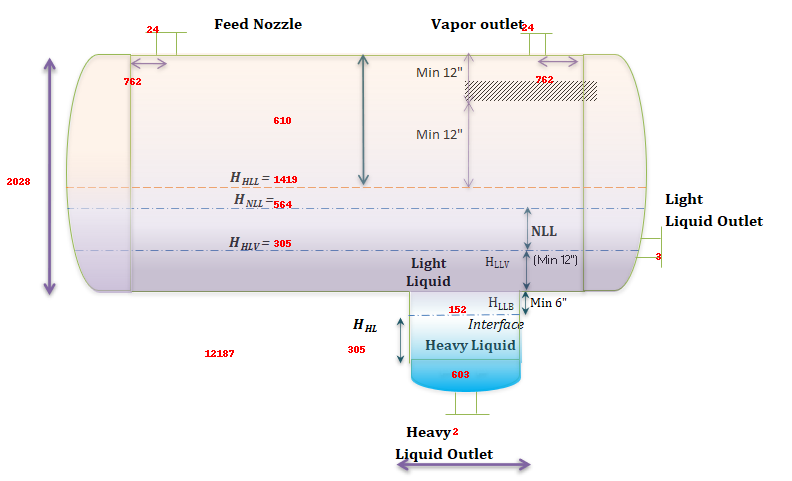

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,2028.41628
1,Vessel Tan-Tan Length,L,mm,12186.62949
2,L/D,-,-,6.00795
3,Shell Thickness,ts,mm,10.0025
4,Head Thickness,tH,mm,10.0025
5,Total Weight,W,kg,6688.51717
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,3.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [ ]:
#  ---------H3P with boots---------------- #

def find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= True):
	Lmin_Ltime , Lmin_V	= -10 , -2
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated
			H_v = max(0.2*D,2)
		else:
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1


		while not 1.2 > (Lmin_Ltime/ Lmin_V) > 0.8 and Lmin_Ltime < 0:
			At = np.pi*0.25*(D**2)
			Hv_D = H_v/(D) # feet / feet

			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At

			# step 7: set the heights of H_HL and H_LL


			A_LLV = height_area_conversion(H_LLV/D ,conversion_to_area = True)*At
			# 9 calculate minimum length
			Lmin_Ltime = (V_H+V_S)/(At-A_v-A_LLV)

			#calculate actual vapor velocity
			# Liquid dropout time
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v
			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi
			if abs(Lmin_Ltime / Lmin_V) > 1.2 and H_v > min_Hv:
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(Lmin_Ltime / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.02
				Hv_D = H_v/(D)
			if Lmin_Ltime <0 :
				D +=0.01
				Hv_D = H_v/(D)
	# print('Hv/D equals {} as D is {} feet and Hv is {} feet'.format(round(Hv_D,3),D,H_v))
	# print('Av is {}'.format(A_v))
	# print('Lmin1 is {} while Lmin2 is {}'.format(round(Lmin_Ltime,2),round(Lmin_V,2)))
	if Lmin_Ltime < Lmin_V:
		L = Lmin_V
	else:
		L = Lmin_Ltime
	#print(D,L)
	U_HL = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True) # velocity of the heavy liq out of the light liq in in/min.
	U_LH = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False)

	t_HL = 12*(H_LLB+D-H_v)/U_HL
	#t_LH = 12*H_HL/U_LH
	phi_LL = (At-A_v)*L/Q_LL
	#print('t_HL is {} while phi_LL is {}'.format(t_HL,phi_LL))
	L_max2 = (t_HL*Q_LL)/(At-A_v)
	L = max(L,L_max2)
	#print('max length is {}, chosen L is {}'.format(round(L_max2,2),L))
	LD = L/D
	H_LL = D - H_v
	A_NLL = (A_LLV) + V_H/L
	NLL = height_area_conversion(A_NLL/At,conversion_to_area = False)*D
	H_LLV_calculated  = H_LL-NLL
	#print('Assumed H_LLV is {} while calculated H_LLV is {}'.format(H_LLV,H_LLV_calculated))
	if return_output_LD == True:
		return [At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,H_v]
	else:
		return LD

def optimize_vessel_design_withBoot(vars,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output = False):
	D,H_LLV,H_LLB = vars
	At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,H_v = find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= True)

	# step 24: Calculate Boot diameter
	H_HL,t_LH , phi_HL = 1, 1,0
	while t_LH > phi_HL:
		H_HL = H_HL + 0.001
		U_p = 0.75 * U_LH
		D_boot = np.sqrt((4*12*Q_HL)/(np.pi*U_p))
		t_LH = 12*H_HL/U_LH
		phi_HL = (np.pi*(D_boot**2)*H_HL)/(4*Q_HL)

	# print('D is {}, Chosen L is {}, Hv is {}, HLL is {}, NLL is {}, HLLV is {},HLLB is {} and H_HL is {}'.format(D,L,H_v,H_LL, NLL, H_LLV,H_LLB,H_HL))
	# print('Boot Diameter is {} ft'.format(D_boot))
	W,t,As,AH,P,T,head_type = weight_calculations(P,T,D,L,17500,1/16,'Dished heads')
	W_boot,t_boot,As_boot,AH_boot,P_boot,T_boot,head_type_boot = weight_calculations(P,T,D_boot,(H_LLB+H_HL),17500,1/16,'Dished heads',boot=True)
	W = W + W_boot
	# print(W,L,D,LD)
	# print('---------------------')
	if return_output == False:
		return W
	else:
		result_list = [D_boot,W,L,D,H_v,H_HL, H_LL ,t,As,AH,P,T,At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,head_type  ]
		return result_list

def LD_constraint_boot6(x,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	D,H_LLV,H_LLB = x[0],x[1],x[2]
	return 6 - find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= False)
def LD_constraint_boot1_5(x,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	D,H_LLV,H_LLB = x[0],x[1],x[2]
	return find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= False) - 1.5

def detailed_V3H_with_boot(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
    Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T= operating_conditions
    hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
    Q_L_mix = Q_oil_lb+ Q_water_lb
    rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
    Ql_mix = Q_L_mix/(60*rho_L)
    sg_oil = rho_oil/62.4
    Qv = Qg_lb /(3600*rho_gas)
    Ql = Q_oil_lb/(60*rho_oil)
    V_H , V_S = hold_up_time*Ql ,surge_time*Ql # ft3
    Q_LL = Q_oil_lb/(60*rho_oil) # ft3/min
    Q_HL = Q_water_lb/(60*rho_water) # ft3/min
    # 1. Calculate Terminal Velocity
    gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
    # 1. Calculate Terminal Velocity

    K = k_GPSA_calculations(P,'Separator without mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
    U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
    # set U_v = 0.75 U_t
    U_v = 0.75* U_t

    # print('Qv is {} ft3/s,QLL is {} ft3/min and QHL is {} ft3/min'.format(round(Qv,2),round(Q_LL,2),round(Q_HL,2)))
    #step 5
    LD = LD_estimate(P) # LD initial estimate (assumption)
    Qhl = Q_water_lb/(60*rho_water)
    gas_vol_fraction = Qv*60/((Qv*60)+Q_LL+Q_HL)
    Q_L_mix = Q_oil_lb+ Q_water_lb
    rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
    Ql_mix = Q_L_mix/(60*rho_L)
    inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
    # print('Estimated LD is {}'.format(LD))
    # print('VHoldup and Vsurge equals {} and {} , total is {} ft3 '.format(round(V_H),round(V_S),(round(V_H)+round(V_S))))
    initial_D = ((4*(V_H + V_S))/(np.pi*0.6*LD))**(1/3) # D in feet
    D = initial_D

    if mist_eliminator: # step 6. used for initial guess and to be minpulated
        H_v = max(0.2*initial_D,2)
    elif gas_mass_fraction*100 > 70:
        H_v = 0.7* initial_D
    else:
        H_v = max(0.2*initial_D,1) # Hv in feet
	#con1,con2,con3,con4 = {'type':'ineq', 'fun': constraint_HP3_Hv_boot, 'args':(V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water)},{'type':'eq', 'fun':constraint_HP3_boot_LD_init, 'args':(V_S,V_H)},	{'type':'ineq', 'fun': LD_constraint_boot1_5, 'args':(V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water)},{'type':'ineq', 'fun': LD_constraint_boot6, 'args':(V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water)} #,{'type':'ineq', 'fun': HLLV_constraint, 'args':(V_S,V_H)}
	#cons=[con1,con2,con3,con4]
    con1,con2 = {'type':'ineq', 'fun':LD_constraint_boot6,'args':(V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)},{'type':'ineq', 'fun':LD_constraint_boot1_5,'args':(V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)}
    cons = [con1,con2]
    initial_guess = [initial_D,1,0.5]
    if mist_eliminator:
        min_Hv = 2
    else: min_Hv = 1
    bounds = [(1,20),(1,20),(0.5,20)]
    result =minimize(optimize_vessel_design_withBoot,args=(P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons)
    result_list = optimize_vessel_design_withBoot(result.x,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output=True)
    D_boot,W,L,D,H_v,H_HL, H_LL ,t,As,AH,P_d,T_d,At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,head_type  = result_list
    #print('W {},D {},L {}, L/D {},t {},D_boot {},H_v {},H_LL {},NLL {},H_LLV {},H_LLB {},H_HL {}'.format(W*0.45,D*304.8,L*304.8,LD,t*25.4,D_boot*304.8,H_v*304.8,H_LL*304.8,NLL*304.8,H_LLV*304.8,H_LLB*304.8,H_HL*304.8))

    d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
    gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
    liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
    liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)
    gas_N = Calculate_N(gas_outlet_D)
    liquid_H_N = Calculate_N(liquid_H_outlet_D)
    Feed_N = Calculate_N(d_n)


    Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_L_outlet_D,liquid_H_outlet_D  ,D*304.8,L*304.8,D_boot*304.8,H_v*304.8,H_LL*304.8,NLL*304.8,H_LLV*304.8,H_LLB*304.8,H_HL*304.8]
    for i,j in enumerate(Dims_results):
        Dims_results[i] = round(float(j))
    coord = [(147,24),(124,76),(522,22),(536,74),(656,251),(453,426),(7,176),(205,348),(452,369),(274,115),(274,174),(274,199),(274,238),(449,304),(348,344)
    ] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
    list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
	['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
	['Low Light Liquid Level', 'HLLV', 'mm', H_LLV*304.8],
	['Normal Light Liquid Level', 'HNLL', 'mm', NLL*304.8],
	['High Light Liquid Level', 'HHLL', 'mm', H_LL*304.8],
	['Boot Light Liquid Level', 'HLLB', 'mm', H_LLB*304.8],
	['High Heavy Liquid Level', 'HHL', 'mm', (H_HL)*304.8],
	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]
    if not mist_eliminator:
        write_results_on_imgs('detailed_method_V3H_boot',Dims_results,coord)
    else:
        write_results_on_imgs('detailed_method_V3H_boot_with_mesh',Dims_results,coord)
    summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
    return summary_table

# Calculations inputs
Qg_lb, rho_gas = 235000,0.19 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 45000,7500,40.5,62.00
mu_oil,mu_water = 0.24, 0.682
sg_oil = rho_oil/rho_water
P = 25 + 14.6959 # psia
T = 100 # F
inlet_divertor, mist_eliminator = False,True
sep_case = 'Unit Feed Drum'
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
summary_table  = detailed_V3H_with_boot(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

#Horizontal Three-Phase Separator Sizing (With weir)

<ipython-input-22-f4c60e4052a2>:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  D = float(vars)


detailed_method_V3H_weir


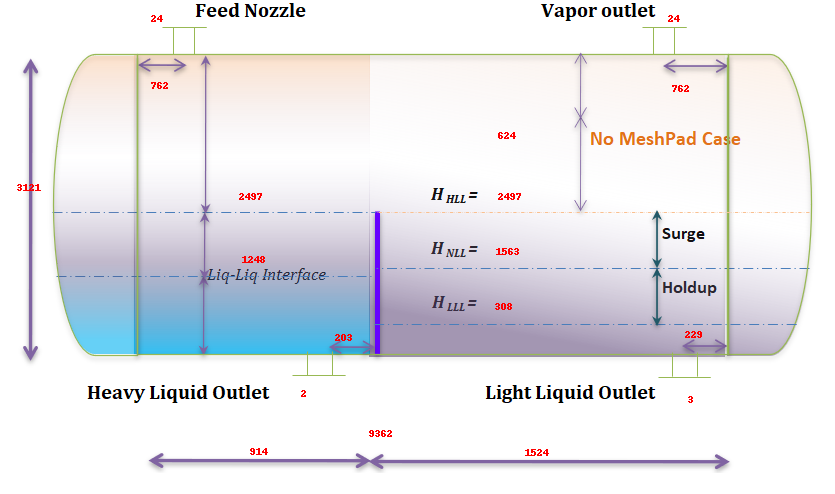

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,3120.66666
1,Vessel Tan-Tan Length,L,mm,9362.0003
2,L/D,-,-,3.0
3,Shell Thickness,ts,mm,11.80294
4,Head Thickness,tH,mm,11.80294
5,Total Weight,W,kg,10022.30812
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,3.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [ ]:
#  ---------H3P with Weir---------------- #
def find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = True):


	L_total , Lmin_V,L2	= -10 , -2 ,-10
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated
			H_v = max(0.2*D,2)
		else:
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1
		while not 1.2 > abs(L_total/ Lmin_V) > 0.8 and L2 < 0 :
			D = float(D)
			At = np.pi*0.25*(D**2) # ft2
			Hv_D = H_v/(D) # feet / feet

			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At

			# step 7: set the heights of H_HL and H_LL
			H_LLL = (0.5*D+7)/12 # feet
			H_w = D-H_v

			#if H_w <2:
			#D+=0.01

			A_LLL = height_area_conversion(H_LLL/D ,conversion_to_area = True)*At

			# 9 calculate minimum length
			L2 = np.ceil((V_H+V_S)/(At-A_v-A_LLL)) #max(,dn+1) # L2
			if return_output_LD == 'L2':
				return L2


			#calculate actual vapor velocity
			# Liquid dropout time
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v
			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi


			#set interface at hw/2
			H_LL,H_HL = H_w/2,H_w/2


			A_HL = height_area_conversion(H_HL/D ,conversion_to_area = True)*At
			A_LL = At - A_v- A_HL

			U_HL = min(terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True),10) # max. velocity is 10 in/min
			U_LH = min(terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False),10) # max. velocity is 10 in/min

			t_HL = 12*(H_LL)/U_HL
			t_LH = 12*H_HL/U_LH

			L1 = np.ceil(max(t_LH*Q_HL/A_HL,t_HL*Q_LL/A_LL))



			L_total = L1 + L2
			if abs(L_total / Lmin_V) > 1.2 and H_v > min_Hv:
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(L_total / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.02
				Hv_D = H_v/(D)
			if L2 <0 :
				D +=0.01
				Hv_D = H_v/(D)
	if L_total < Lmin_V:
		L = Lmin_V
		# set new L1 and L2
	else:
		L = L_total
	# print('Uav is {} while  phi is {}'.format(round(U_VA,2),round(phi,2)))
	# print('Lmin1 is {} while Lmin2 is {}'.format(round(L2,2),round(Lmin_V,2)))
	# print('Hv/D equals {} as D is {} feet and Hv is {} feet'.format(round(Hv_D,3),D,H_v))
	# print('Hw is {}'.format(H_w))
	# print('At {},Av equals {}, A_LLL equals {}, L2 {}'.format(At,A_v,A_LLL,L2))
	# print('U_HL is {} in/min. U_LH is {} in/min. t_HL = {} mins and t_LH is {} mins'.format(round(U_HL,2),round(U_LH,2),round(t_HL,2),round(t_LH,2)))
	# print('first option for L1 is {}, second is {}, {} was selected'.format(t_LH*Q_HL/A_HL,t_HL*Q_LL/A_LL,L1))
	# print('L1 = {}, L2 = {}. Consequently L total is {} while Lmin is {}. Selected L is {} '.format(round(L1,2),round(L2,2),round(L_total,2),round(Lmin_V,2),round(L,2)))
	phi_LL = (At-A_v)*L/Q_LL
	L_max2 = (t_HL*Q_LL)/(At-A_v)
	L = max(L,L_max2)

	if return_output_LD == True:
		return [At,Hv_D,A_v,H_LLL,H_w,A_LLL,L2,phi,U_VA,Lmin_V,H_LL,H_HL,A_HL,A_LL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,L_max2,L,H_v]
	else:
		return L/D
def optimize_vessel_design_HwithW(vars,P,T,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output = False):
	D = float(vars)


	At,Hv_D,A_v,H_LLL,H_w,A_LLL,L2,phi,U_VA,Lmin_V,H_LL,H_HL,A_HL,A_LL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,L_max2,L,H_v = find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = True)
	# print('max length is {}'.format(round(L_max2,2)))
	LD = L/D
	# print('Calculated L/D is {}'.format(LD))
	W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D,L,17500,1/16,'Dished heads',E=0.85)

	H_HLL = D - H_v
	A_NLL = A_LLL + V_H/L2
	H_NLL = height_area_conversion(A_NLL/At,conversion_to_area = False)*D
	# print('Diameter is {} ft, Hv is {} ft,H_LL & H_HL are {} and {} ft'.format(round(float(D),2),round(float(H_v),2),round(H_LL,2),round(H_HL,2)))
	# print(W,L,D,LD)
	# print('---------------------')
	if return_output == False:
		return W
	else:
		result_list = [W,L,D,H_v,t,As,AH,P,T,At,A_v,H_LLL,H_w,L2,phi,U_VA,Lmin_V,H_LL,H_HL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,H_HLL,H_NLL,LD,head_type]
		return result_list

def constraint_H3P_weir_1_5(x,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	# assumed LD equals calculated LD
	D = x[0]
	return find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = False) - 1.5
def constraint_H3P_weir_6(x,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	# assumed LD equals calculated LD
	D= x[0]
	return 3 - find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = False)
def detailed_V3H_with_weir(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
	Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T= operating_conditions
	hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
	Q_L_mix = Q_oil_lb+ Q_water_lb
	rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
	Ql_mix = Q_L_mix/(60*rho_L)
	sg_oil = rho_oil/62
	# 1. Calculate Terminal Velocity
	Qv = Qg_lb /(3600*rho_gas)
	Ql = Q_oil_lb/(60*rho_oil)
	V_H , V_S = hold_up_time*Ql ,surge_time*Ql # ft3
	Q_LL = Q_oil_lb/(60*rho_oil) # ft3/min
	Q_HL = Q_water_lb/(60*rho_water) # ft3/min
	# print('Qv is {} ft3/s,QLL is {} ft3/min and QHL is {} ft3/min'.format(round(Qv,2),round(Q_LL,2),round(Q_HL,2)))
	gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
	d_n = inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)
	gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
	Qhl = Q_water_lb/(60*rho_water)
	gas_vol_fraction = Qv*60/((Qv*60)+Q_LL+Q_HL)
	# print('gas_vol_fraction is {}'.format(gas_vol_fraction))
	# print('gas_mass_fraction is {}'.format(gas_mass_fraction))
	Q_L_mix = Q_oil_lb+ Q_water_lb
	rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
	Ql_mix = Q_L_mix/(60*rho_L)
	# 1. Calculate Terminal Velocity

	K = k_GPSA_calculations(P,'Separator without mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
	U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
	# set U_v = 0.75 U_t
	U_v = 0.75* U_t

	#step 5
	LD = LD_estimate(P) # LD initial estimate (assumption)

	# print('Estimated LD is {}'.format(LD))
	# print('VHoldup and Vsurge equals {} and {} , total is {} ft3 '.format(round(V_H),round(V_S),(round(V_H)+round(V_S))))
	initial_D = round(((16*(V_H + V_S))/(np.pi*0.6*LD))**(1/3)) # D in feet

	# print('inital Diameter is {}'.format(initial_D))

	#print('--------------------------')
	con1,con2 = {'type':'ineq', 'fun': constraint_H3P_weir_1_5, 'args':(V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)},{'type':'ineq', 'fun': constraint_H3P_weir_6, 'args':(V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)} # {'type':'ineq', 'fun': constraint_HP2_2},
	cons = [con1,con2]

	initial_guess = [initial_D]

	bounds = [(1,20)]
	result =minimize(optimize_vessel_design_HwithW,args=(P,T,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.001,constraints=cons) #, constraints= cons)
	result_list = optimize_vessel_design_HwithW(result.x,P,T,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output=True)
	W,L,D,H_v,t,As,AH,P_d,T_d,At,A_v,H_LLL,H_w,L2,phi,U_VA,Lmin_V,H_LL,H_HL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,H_HLL,H_NLL,LD,head_type = result_list



	d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
	gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
	liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
	liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)
	gas_N = Calculate_N(gas_outlet_D)
	liquid_L_N = Calculate_N(liquid_L_outlet_D)
	liquid_H_N = Calculate_N(liquid_H_outlet_D)
	Feed_N = Calculate_N(d_n)
	Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_L_outlet_D,liquid_L_N,liquid_H_outlet_D,liquid_H_N,L*304.8 ,D*304.8,L1*304.8,L2*304.8,H_HLL*304.8,H_NLL*304.8,H_LLL*304.8,(H_HL+H_LL)*304.8,H_LL*304.8,H_v*304.8]
	for i,j in enumerate(Dims_results):
		Dims_results[i] = round(float(j))
	coord = [(151,13),(151,80),(668,13),(672,83),(688,394),(685,329),(301,388),(335,332),(369,428),(17,182),(250,446),
	(525,447),(498,191),(496,246),(495,301),(239,191),(242,254),(498,130)]
	list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
	['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
	['Low Light Liquid Level', 'HLLL', 'mm', H_LLL*304.8],
	['Normal Light Liquid Level', 'HNLL', 'mm', H_NLL*304.8],
	['High Light Liquid Level', 'HHLL', 'mm', H_HLL*304.8],
	['Low Heavy Liquid Level', 'HLLL', 'mm', H_LL*304.8],
	['High Heavy Liquid Level', 'HHLL', 'mm', (H_HL+H_LL)*304.8],
	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]

	if not mist_eliminator:
		write_results_on_imgs('detailed_method_V3H_weir',Dims_results,coord)
	else:
		write_results_on_imgs('detailed_method_V3H_weir_with_mesh',Dims_results,coord)
	summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=False)
	return summary_table

# Calculations inputs
Qg_lb, rho_gas = 235000,0.19 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 45000,7500,40.5,62.00
mu_oil,mu_water = 0.24, 0.682
sg_oil = rho_oil/rho_water
P = 25 + 14.6959 # psia
T = 100 # F
inlet_divertor, mist_eliminator = False,True
sep_case = 'Unit Feed Drum'
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
summary_table =detailed_V3H_with_weir(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False)

summary_table